# TP : Sentiment analysis on IMDB movie reviews

## Objectives:

1. Use a simple way to represent textual data - Bag of words
2. Test it with a simple model for a sentiment classification task - Naïve Bayesian
3. Explore improvements to these simple representations
4. Explore various methods to obtain dense representations (word embeddings) of the same data
5. Test these new representations with a simple classification model
6. Fine-tune a BERT model to execute the same classification task

## Necessary dependencies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Both are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [162]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
# !pip install gensim==4.1.2 # install the latest version if errors arise with gensim

## Loading data

We retrieve the textual data in the variable *texts*.

The labels are retrieved in the variable $y$ - it contains *len(texts)* of them: $0$ indicates that the corresponding review is negative while $1$ indicates that it is positive.

In [163]:
# For those on google colab: you can download the files directly with this:
import gdown
gdown.download("http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", output="aclImdb_v1.tar.gz", quiet=False)
!tar xzf /content/aclImdb_v1.tar.gz

Downloading...
From: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
To: /content/aclImdb_v1.tar.gz
100%|██████████| 84.1M/84.1M [00:01<00:00, 43.2MB/s]


In [164]:
from glob import glob
# We get the files from the path: ./aclImdb/train/neg for negative reviews, and ./aclImdb/train/pos for positive reviews
train_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'train', 'neg', '*.txt')))
train_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'train', 'pos', '*.txt')))

"""
test_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'test', 'neg', '*.txt')))
test_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'test', 'pos', '*.txt')))
"""

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos

"""
test_texts_neg = [open(f, encoding="utf8").read() for f in test_filenames_neg]
test_texts_pos = [open(f, encoding="utf8").read() for f in test_filenames_pos]
test_texts = test_texts_neg + test_texts_pos
"""

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
train_labels = np.ones(len(train_texts), dtype=int)
train_labels[:len(train_texts_neg)] = 0.

"""
test_labels = np.ones(len(test_texts), dtype=np.int)
test_labels[:len(test_texts_neg)] = 0.
"""

'\ntest_labels = np.ones(len(test_texts), dtype=np.int)\ntest_labels[:len(test_texts_neg)] = 0.\n'

Example of one document:

In [165]:
open("./aclImdb/train/neg/0_3.txt", encoding="utf8").read()

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

**In this lab, the impact of our choice of representations upon our results will also depend on the quantity of data we use:** try to see how changing the parameter ```k``` affects our results !

In [166]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 100
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]

print('Number of documents:', len(train_texts_reduced))

Number of documents: 250


We can use a function from sklearn, ```train_test_split```, to separate data into training and validation sets:

In [167]:
from sklearn.model_selection import train_test_split

In [168]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts_reduced, train_labels_reduced, test_size=.2)

## Adapted representation of documents

Our statistical model, like most models applied to textual data, uses counts of word occurrences in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, containing the counts of each word (regardless of their order of occurrence) in the document. 

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to each $w$ word an integer, which will be its position in $V$. 

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document. 

We can use the **CountVectorizer** class from scikit-learn to obtain these representations:

In [169]:
from sklearn.feature_extraction.text import CountVectorizer

In [170]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names())
Bow.toarray()

['avenue', 'boulevard', 'city', 'down', 'ran', 'the', 'walk', 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]])

Careful: check the memory that the representations are going to use (given the way they are build). What ```CountVectorizer``` argument allows to avoid the issue ? <br>
**Answer**: For each document in the corpus, we take into account the number of occurences of <u>all</u> unique words in the corpus which results in the length of $|V|$ (for each document). However, some words for a given document may occur less or even, have no frequency. Thus, to reduce the length of this representation, one can benefit from the *max_features* parameter of CountVectorizer, which allows us to keep only the top max_features words based on their frequency. Consequently, this results in the reduction of the lenght for the document representation.


In [171]:
# Create and fit the vectorizer to the training data
vectorizer = CountVectorizer()
Bow = vectorizer.fit_transform(train_texts_splt)

In [172]:
# Transform the validation data
val_texts_transformed = vectorizer.transform(val_texts)

We are going to use the scikit-learn ```MultinomialNB```, an implementation of the Naive Bayesian model. Here, what is the naïve hypothesis ? <br>
**Answer**: In this scenario, naïveness is related to the fact that the probability of occurence for each word (feature) within a document (or in different documents) is independent.

In [173]:
from sklearn.naive_bayes import MultinomialNB

In [174]:
# Fit the model on the training data

multinomial_nb = MultinomialNB()
multinomial_nb.fit(Bow, train_labels_splt)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [175]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

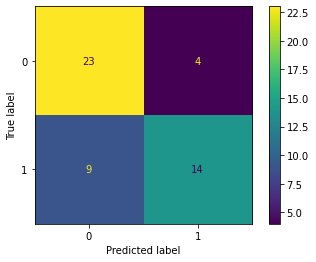

              precision    recall  f1-score   support

           0       0.72      0.85      0.78        27
           1       0.78      0.61      0.68        23

    accuracy                           0.74        50
   macro avg       0.75      0.73      0.73        50
weighted avg       0.75      0.74      0.74        50



In [176]:
# Test it on the validation data
y_pred = multinomial_nb.predict(val_texts_transformed)
cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multinomial_nb.classes_)
disp.plot()
plt.show()
print(classification_report(val_labels, y_pred))

Let us look at the *features* built by the ```vectorizer```. How can we improve them ? <br>
**Answer**: After printing some features below, we may see numbers with some letters following them, causing redundancy in some sense (for example, '70' and '70th' point to the same meaning of 70). We can apply some sort of stemming to remove the ending letters, which may result in a simpler representation. This can be applied not only on numbers, but also on words (for ex, abandoned --> abandon).

In [301]:
print(vectorizer.get_feature_names()[:100])

['01', '10', '100', '11', '12', '13', '14', '15', '16', '17', '180', '1840', '1840s', '1920', '1930s', '1934', '1940s', '1944', '1950', '1953', '1954', '1959', '1960s', '1964', '1965', '1968', '1969', '1970', '1970s', '1971', '1973', '1974', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1989', '1992', '1993', '1994', '1995', '1996', '1997', '1999', '19th', '20', '2000', '2004', '2005', '2006', '2031', '22', '24', '25', '250', '269', '28', '2nd', '30', '35', '35mm', '36', '37', '3d', '3rd', '40', '44', '45', '4m', '4th', '4w', '50', '5000', '50s', '5th', '60', '65', '70', '70mm', '70s', '70th', '74', '750', '80', '80s', '90', '94', '99', '998', 'aaaand', 'abandoned', 'abc', 'ability', 'able', 'ably']


### Improving representations

Mainly, the arguments of the class ```vectorizer``` will allow us to easily change the way our textual data is represented. Let us try to work on our *Bag-of-words* representations:
   
#### Do not take into account words that are too frequent:

You can use the argument ```max_df=1.0``` to change the amount of words taken into account. 

#### Try different granularities:

Rather than just counting words, we can count sequences of words - limited in size, of course. 
We call a sequence of $n$ words a $n$-gram: let's try using 2 and 3-grams (bi- and trigrams).
We can also try to use character sequences instead of word sequences.

We will be interested in the options ```analyze='word'``` and ```ngram_range=(1, 2)``` which we'll change to alter the granularity. 

**Again: using these ways of getting more features from our text will probably have more impact if we do not have much training data to begin with !**

To accelerate experiments, use the ```Pipeline``` tool from scikit-learn. 

In [178]:
from sklearn.pipeline import Pipeline

In [179]:
pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
# Fit and test the pipeline
pipeline_base.fit(train_texts_splt, train_labels_splt)
print('Score:', pipeline_base.score(val_texts, val_labels))

Score: 0.74


In [180]:
# Fit and test a pipeline with bigrams
pipeline_bigram = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None, ngram_range = (2, 2))),
    ('clf', MultinomialNB()),
])
pipeline_bigram.fit(train_texts_splt, train_labels_splt)
print('Score:', pipeline_bigram.score(val_texts, val_labels))

Score: 0.66


In [181]:
# ... trigrams
pipeline_trigram = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None, ngram_range = (3, 3))),
    ('clf', MultinomialNB()),
])
pipeline_trigram.fit(train_texts_splt, train_labels_splt)
print('Score:', pipeline_trigram.score(val_texts, val_labels))

Score: 0.72


In [182]:
# ... and characters
pipeline_char = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='char', stop_words=None)),
    ('clf', MultinomialNB()),
])
pipeline_char.fit(train_texts_splt, train_labels_splt)
print('Score:', pipeline_char.score(val_texts, val_labels))

Score: 0.62


#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents. 

In [183]:
from sklearn.feature_extraction.text import TfidfTransformer

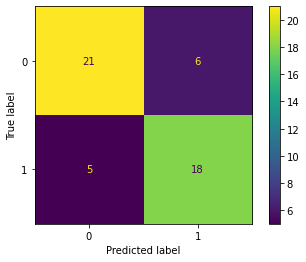

              precision    recall  f1-score   support

           0       0.81      0.78      0.79        27
           1       0.75      0.78      0.77        23

    accuracy                           0.78        50
   macro avg       0.78      0.78      0.78        50
weighted avg       0.78      0.78      0.78        50

Score: 0.78


In [184]:
# Fit and test a pipeline with tf-idf

pipe = Pipeline([('count', CountVectorizer()),
                  ('tfid', TfidfTransformer())])
pipe.fit(train_texts_splt, train_labels_splt)
val_texts_transformed = pipe.transform(val_texts)
y_pred = multinomial_nb.predict(val_texts_transformed)

cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multinomial_nb.classes_)
disp.plot()
plt.show()
print(classification_report(val_labels, y_pred))
print('Score:', multinomial_nb.score(val_texts_transformed, val_labels))

### Pre-processing tools: NLTK

We are now going to pre-process our textual data in order to simplify the model's task. **Note that this still will only be useful if we do not have a lot of training data to begin with !**

**Important:** Until now, we obtained representations with ```vectorizer``` applied on the full document. The class divided the string into words itself ! Now, we'll need to do the **tokenization** ourselves in order to apply pre-processing to words. The simplest way to do this is to divide the string following blank spaces, with:
```text.split()```. If we need something more elaborate, we can use a tokenizer from NLTK, ```word_tokenize```.

### Stemming 

Allows to go back to the root of a word: you can group different words around the same root, which facilitates generalization. Use:
```from nltk import SnowballStemmer```

In [185]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")

**Example:**

In [186]:
words = ['singers', 'cat', 'generalization', 'philosophy', 'psychology', 'philosopher']
for word in words:
    print('word : %s ; stemmed : %s' %(word, stemmer.stem(word)))#.decode('utf-8'))))

word : singers ; stemmed : singer
word : cat ; stemmed : cat
word : generalization ; stemmed : general
word : philosophy ; stemmed : philosophi
word : psychology ; stemmed : psycholog
word : philosopher ; stemmed : philosoph


**Data transformation:**

In [187]:
def stem(X):
    #
    # To complete 
    #
    X_stem = []
    for doc in X:
        words = doc.split()
        new_doc = ''
        for word in words:
            word_stem = stemmer.stem(word)
            new_doc += (word_stem+' ')
        X_stem.append(new_doc[:-1]) # avoids last blank space character
    return X_stem

In [188]:
# Transform training and validation data and test it with a basic pipeline
train_stem = stem(train_texts_splt)
val_stem = stem(val_texts)

pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
# Fit and test the pipeline
pipeline_base.fit(train_stem, train_labels_splt)
print('Score:', pipeline_base.score(val_stem, val_labels))

Score: 0.84


### Part of speech tags

To generalize, we can also use the Part of Speech (POS) of the words, which will allow us to filter out information that is potentially not useful to the model. We will retrieve the POS of the words using the functions:
```from nltk import pos_tag, word_tokenize```

In [189]:
import nltk
from nltk import pos_tag, word_tokenize

**Example:**

In [190]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pos_tag(word_tokenize(('I am Sam')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('I', 'PRP'), ('am', 'VBP'), ('Sam', 'NNP')]

**Data transformation:** only keep nouns, verbs, adverbs, and adjectives (```['NN', 'VB', 'ADJ', 'RB']```) for our model.

In [191]:
def pos_tag_filter(X, good_tags=['NN', 'VB', 'JJ', 'RB']):
    #
    # To complete 
    #
    X_postag = []
    for doc in X:
        words_pos_tags = pos_tag(word_tokenize(doc))
        new_doc = ''
        for pair in words_pos_tags:
            if pair[1] in good_tags:
                new_doc += (pair[0]+' ')
        X_postag.append(new_doc[:-1]) # avoids last blank space character

    return X_postag

In [192]:
# Transform training and validation data and test it with a basic pipeline
train_postag = pos_tag_filter(train_texts_splt)
val_postag = pos_tag_filter(val_texts)

pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
# Fit and test the pipeline
pipeline_base.fit(train_postag, train_labels_splt)
print('Score:', pipeline_base.score(val_postag, val_labels))

Score: 0.82


# Dense Representations 

##  Word Embeddings : Distributed representations via the distributional hypothesis 

**Goal**: We will try to obtain dense representations (as vectors of real numbers) of words (and possibly sentences). These representations are intended to be distributed: they are non-local representations. We represent an object as a combination of *features*, as opposed to the attribution of a dedicated symbol: see the founding work of Geoffrey Hinton, among others, on the subject: [Distributed Representations](https://web.stanford.edu/~jlmcc/papers/PDP/Chapter3.pdf).

The term *distributed* representations is very general, but is what we are looking for. The challenge is therefore to be able to build, automatically, such representations.

**Underlying idea**: It is based on the distributional hypothesis: contextual information is sufficient to obtain a viable representation of linguistic objects.
 - For a large class of cases [...] the meaning of a word is its use in the language." Wittgenstein (Philosophical Investigations, 43 - 1953)
 - You shall know a word by the company it keeps, Firth.

Thus, a word can be characterized by the words that accompany it, via co-occurrence counts. Two words with a similar meaning will have a similar contextual distribution and are therefore more likely to appear in similar contexts. This hypothesis can be used as a justification for the application of statistics to semantics (information extraction, semantic analysis). It also allows some form of generalization: we can assume that the information we have about a word will be generalized to words with a similar distribution. 

**Motivation**: The goal is to obtain distributed representations in order to be able to effectively**:
- Directly perform a semantic surface analysis.
- Use it as a source of information for other language-related models and applications, especially for sentiment analysis. 


**Terminology**: Be careful not to confuse the idea of *distributed* and *distributional* representation. The latter generally indicates (for words) that the representation has been obtained strictly from co-occurrence counts, whereas additional information (document labels, part of speech tags, ...) can be used to build distributed representations. 
The models that allow to build these dense representations, in the form of vectors, are often called *vector spaces models*. These representations are also regularly called *word embeddings*, because the words are embedded in a vector space. In French, we often find the term *word embedding* or *lexical embedding*.

## Getting representations: counts of occurrences and co-occurrences

Depending on the type of corpus available, different types of distributional information can be obtained. If we have access to a collection of documents, we can thus choose to count the number of occurrences of each word in each document, to obtain a $words \times documents$ matrix: it is on this principle that **Tf-Idf** is built. We will now look at a more general case: we have a large amount of data in text form, and we want to obtain representations of words in the form of vectors of reduced size, without the need to divide them into documents or categories. 

Suppose we have a corpus containing $T$ different words. We will construct a $\mathbf{M}$ matrix of size $T \times T$ which will contain the number of co-occurrences between words. There will be different factors to consider when constructing this matrix: 

- How do you define the 'context' of a word - context which will tell you what terms co-occur with that word?

We can choose to use different scales: the document, the sentence, the nominal group, or simply a window of $k$ words, depending on the information we want to capture.


- How do we quantify the importance of the counts? 

$\rightarrow$ For example, we can give a decreasing weight to a co-occurrence according to the distance between the two words concerned ($\frac{1}{d+1}$ for a separation by $d$ words).


- Should we keep all the words that appear in the corpus? 

$\rightarrow$ Usually not. We will see that for large corpora, the number $T$ of different words is huge. Second, even if the number of words is reasonable, we will have very little distributional information on the rarest words, and the representation obtained will be of poor quality. We will have to ask ourselves how to filter these words, and how to treat the words we choose not to represent.  

#### Example:

Let's look at the following text:

*I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue.*

We choose to define the context of a word as the sentence to which it belongs, and to not use any weighting.
We obtain the following matrix: 

|     *         | I | the | down | walked | boulevard | avenue | walk | ran | city |
|---------------|---|-----|------|--------|-----------|--------|------|-----|------|
| I             | 0 |      6 |    6 |   2 |         2 |      2 |   2 |    1 |    1 |
| the           | 6 |      2 |    7 |   2 |         2 |      3 |   3 |    1 |    1 |
| down          | 6 |      7 |    2 |   3 |         3 |      2 |   2 |    1 |    1 |
| walked        | 2 |      2 |    3 |   0 |         1 |      1 |   0 |    0 |    0 |
| boulevard     | 2 |      2 |    3 |   1 |         0 |      0 |   0 |    1 |    0 |
| avenue        | 2 |      3 |    2 |   1 |         0 |      0 |   1 |    0 |    0 |
| ran           | 2 |      3 |    2 |   0 |         0 |      1 |   0 |    0 |    1 |
| walk          | 1 |      1 |    1 |   0 |         1 |      0 |   0 |    0 |    0 |
| city          | 1 |      1 |    1 |   0 |         0 |      0 |   1 |    0 |    1 |

## Modifying the representations:

We may want to alter the representations to obtain better features - depending on what use we will have for them.

**Normalization**: Very easy: we want to cancel the influence of the magnitude of the counts on the representation.

$$\mathbf{m_{normalized}} = \left[ 
   \frac{m_{1}}{\sum_{i=1}^{n}m_{i}}, 
   \frac{m_{2}}{\sum_{i=1}^{n}m_{i}}, 
   \ldots
   \frac{m_{n}}{\sum_{i=1}^{n}m_{i}}, 
\right]$$
 
**Pointwise Mutual Information**: The aim is to assess the extent to which the co-occurrence of the two terms is *unexpected*. This measure is the ratio of the joint probability of the two words and the product of their individual probabilities:
$$
\text{PMI}(x,y) = \log \left( \frac{P(x,y)}{P(x)P(y)} \right)
$$
The joint probability of the two words corresponds to the number of times they are observed together, divided by the total number of co-occurrences in the corpus: 
$$ P(\mathbf{M},w_{1},w_{2}) = \frac{M_{w_{1},w_{2}}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
The individual probability of a word simply corresponds to its frequency, which can be calculated by counting all co-occurrences where that word appears:
$$ P(\mathbf{M},w) = \frac{\sum_{j=1}^{m} M_{w,j}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
Hence,
$$ 
\text{PMI}(\mathbf{M},w_{1},w_{2}) = \log  \frac{M_{w_{1},w_{2}} \times \left( \sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j} \right)}{\left( \sum_{j=1}^{n} M_{w_{1},j} \right) \times \left( \sum_{i=1}^{n}M_{i,w_{2}} \right)} 
$$
We thus calculate the discrepancy between the observation we have made in our corpus and the frequency of appearance of these terms if we consider them independent - i.e. we assume that their co-occurrence is a coincidence.

The main problem with this measure is that it is not adapted to the case where no co-occurrence is observed. Since the PMI is supposed to return a positive quantity if more co-occurrences are observed than expected, and a negative quantity if fewer co-occurrences are observed, we cannot choose to replace $\log(0)$ by $0$. A commonly used solution is to use the **Positive PMI**, which sets all negative values to $0$.
 
 $$\text{PPMI}(\mathbf{M},w_{1},w_{2}) = 
 \begin{cases}
 \text{PMI}(\mathbf{M},w_{1},w_{2}) & \textrm{if } \text{PMI}(\mathbf{M},w_{1},w_{2}) > 0 \\
 0 & \textrm{otherwise}
 \end{cases}$$

### Co-occurences matrix : reducing the dimension

#### Motivation

The aim is not only to reduce the size of the data (thus, we will deal with vectors of reduced dimensions, rather than working with vectors of the size of the vocabulary) but also to highlight higher level relationships between words: by reducing their representations to the *most important* dimensions of the data, we *generalize* certain properties between words.

#### Dimension reduction via SVD 

A matrix is a linear transformation: applying an SVD to it means decomposing our linear transformation into a product of linear transformations of different types. In fact, we will change the basis of our vector, and replace our data in a space where each of the coordinates are unchanged by the transformation carried out. Thus, we decompose the matrix $\mathbf{M}$ into three matrices:

$$ \mathbf{M} = \mathbf{U} \mathbf{\lambda} \mathbf{V}^{\text{T}} $$

Matrices $\mathbf{U}$, $\mathbf{\lambda}$, et $\mathbf{V}$ have the following properties:
- $\mathbf{U}$ and $\mathbf{V}$ are orthogonal matrices ($\mathbf{U}^{\text{T}} = \mathbf{U}^{-1}$ and $\mathbf{V}^{\text{T}} = \mathbf{V}^{-1}$). They contain the eigen vectors to the right and to the left of $\mathbf{M}$.
- $\mathbf{\lambda}$ is a diagonal matrix: careful, it's not necessarily square. Values on the diagonal are the eigenvalues of $\mathbf{M}$.

Thus, the *most important* dimensions correspond to the largest eigenvalues. Reducing our data to $k$ dimensions corresponds to keeping only the vectors corresponding to the first $k$ eigenvalues - and this is equivalent to taking the first $k$ vectors of the $U$ matrix. 

Note: When we apply this method to the matrix of $\mathbf{M}$ counts of dimension $T \times D$, where $\mathbf{M}_{t,d}$ contains the number of occurrences of the word $t$ in the document $d$, we obtain the method called **Latent Semantic Analysis**, for the detection of latent (semantic) components allowing the grouping of documents.  

### In practice: get a Vocabulary.

To begin, we will implement separately a function returning the vocabulary. Here we will have to be able to control its size, either by indicating a maximum number of words, or a minimum number of occurrences to take the words into account. We add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary. 

Reminder: use tokenization to obtain words from a document !

In [193]:
def vocabulary(corpus, count_threshold=1, voc_threshold=0):
    """    
    Function using word counts to build a vocabulary - can be improved with a second parameter for 
    setting a frequency threshold
    Params:
        corpus (list of list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary 
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency        
    """
    #
    # To complete 
    #   
    word_counts = {}
    for doc in corpus:
        words = doc.split()
        for word in words:
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
    word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))
    
    filtered_word_counts = {}
    for key in word_counts:
        if word_counts[key] >= count_threshold:
            filtered_word_counts[key] = word_counts[key]
        if voc_threshold != 0:
            if len(filtered_word_counts) == voc_threshold:
                break
    
    filtered_word_counts['UNK'] = 0
    vocabulary = {}
    vocabulary_word_counts = {}
    vocabulary_word_counts = filtered_word_counts
    
    for index, (key, value) in enumerate(filtered_word_counts.items()):
        vocabulary[key] = index
    vocabulary['UNK'] = len(vocabulary)-1
    
    return vocabulary, vocabulary_word_counts

In [194]:
# Example for testing:

corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus, count_threshold = 3)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

voc, counts = vocabulary(corpus)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

{'down': 0, 'the': 1, 'I': 2, 'UNK': 3}
{'down': 6, 'the': 6, 'I': 5, 'UNK': 0}
{'down': 0, 'the': 1, 'I': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
{'down': 6, 'the': 6, 'I': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}


#### Application to a real data set

We're going to work with the **imdb** data.

#### Quick study of the data

We would like to get an idea of what's in these film reviews before we proceed. So we'll get the vocabulary (in full) and represent the frequencies of the words, in order (be careful, you'll have to use a logarithmic scale): we should find back Zipf's law. This will give us an idea of the size of the vocabulary we will be able to choose: it's a matter of making a compromise between the necessary resources (size of the objects in memory) and the amount of information we can get from them (rare words can bring a lot of information, but it's difficult to learn good representations of them, because they are rare!).  

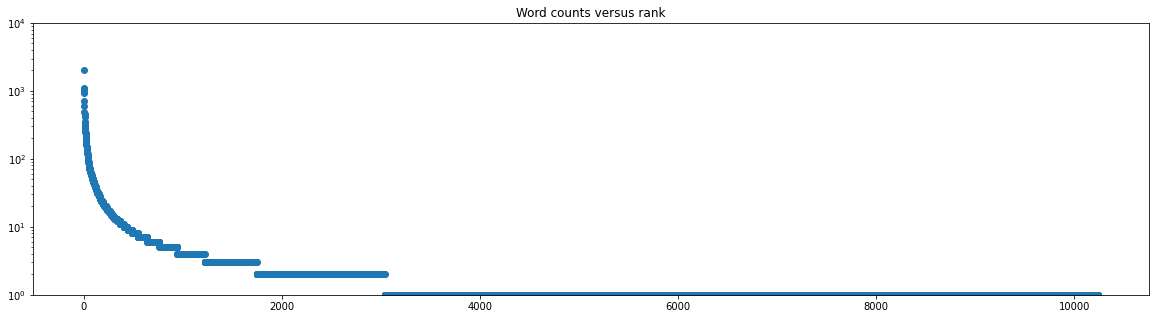

Vocabulary size: 10242
Part of the corpus by taking the "x" most frequent words ?


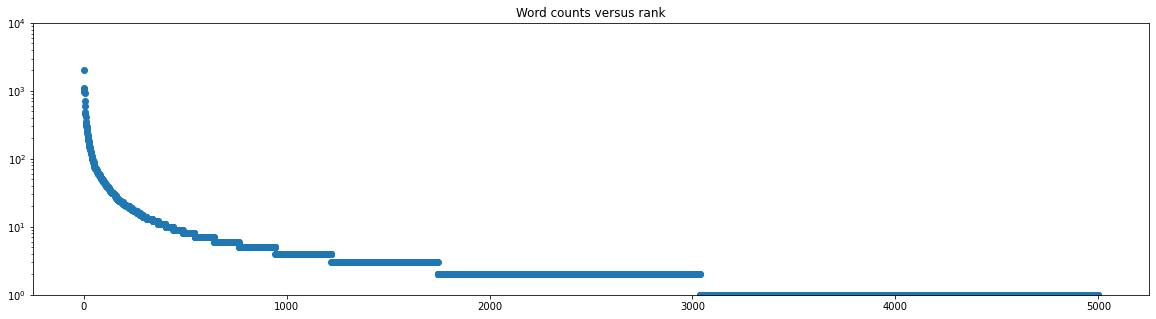

Vocabulary size: 5001


In [318]:
# We would like to display the curve of word frequencies given their rank (index) in the vocabulary
# texts = corpus
texts = train_texts_splt
vocab, word_counts = vocabulary(texts)
#
#  To fill in !
#
# We can for example use the function plt.scatter()
plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.scatter(vocab.values(), word_counts.values())
plt.yscale('log')
plt.ylim(1,10000)
plt.show()
# We would like to know how much of the data is represented by the 'k' most frequent words
print('Vocabulary size: %i' % len(vocab))
print('Part of the corpus by taking the "x" most frequent words ?')

texts = train_texts_splt
vocab, word_counts = vocabulary(texts, voc_threshold = 5000)
plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.scatter(vocab.values(), word_counts.values())
plt.yscale('log')
plt.ylim(1,10000)
plt.show()
print('Vocabulary size: %i' % len(vocab))

**Result of the analysis**: we can be satisfied with a vocabulary of 10,000 or even 5,000 words - this is important, because it will determine the size of the objects we will manipulate. 

In [269]:
vocab_5k, word_counts_5k = vocabulary(train_texts, 0, 5000)

In [270]:
print(vocab_5k['cinema'])

719


We could here compute the co-occurence matrix, and then reduce its dimension. Instead, we will use two of the most popular methods used to produce dense word representations (word embeddings). These methods are very different in practice, but are conceptually close, and resemble the procedure described earlier: reducing the dimension of co-occurences metrics.

## Getting a representation: commonly used algorithms

The idea here is to define a set of representations ${w_{i}}_{i=1}^{V}$, of predefined dimension $d$ (here, we will work with $d = 300$), for all the words $i$ of the vocabulary $V$ - then **train** these representations to match what we want. 

### Word2Vec


####  The skip-gram model

The basic skip-gram model estimates the probabilities of a pair of words $(i, j)$ to appear together in data:

$$P(j \mid i) = \frac{\exp(w_{i} c_{j})}{\sum_{j'\in V}\exp(w_{i} c_{j'})}$$


where $w_{i}$ is the lign vector (of the word) $i$ and $c_{j}$ is the column vector (of a context word) $j$. The objective is to minimize the following quantity:


$$ -\sum_{i=1}^{m} \sum_{k=1}^{|V|} \textbf{1}\{o_{i}=k\} \log \frac{\exp(w_{i} c_{k})}{\sum_{j=1}^{|V|} \exp(w_{i} c_{j})}$$


where $V$ is the vocabulary.
The inputs $w_{i}$ are the representations of the words, which are updated during training, and the output is an *one-hot* $o$ vector, which contains only one $1$ and $0$. For example, if `good` is the 47th word in the vocabulary, the output $o$ for an example or `good` is the word to predict will consist of $0$s everywhere except $1$ in the 47th position of the vector. `good` will be the word to predict when the input $w$ is a word in its context.
We therefore obtain this output with standard softmax - we add a bias term $b$ .


$$ o = \textbf{softmax}(w_{a}C + b)$$


If we use the set of representations for the whole vocabulary (the matrix $W$) as input, we get:


$$ O = \textbf{softmax}(WC + b)$$


and so we come back to the central idea of all our methods: we seek to obtain word representations from co-occurrence counts. Here, we train the parameters contained in $W$ and $C$, two matrices representing the words in reduced dimension (300) so that their scalar product is as close as possible to the co-occurrences observed in the data, using a maximum likelihood objective.

#### Skip-gram with negative sampling

The training of the skip-gram model implies to calculate a sum on the whole vocabulary, because of the **softmax**. As soon as the size of the vocabulary increases, it becomes impossible to compute. In order to make the calculations faster, we change the objective and use the method of *negative sampling* (or, very close to it, the *noise contrastive estimation*).


If we note $\mathcal{D}$ the data set and we note $\mathcal{D}'$ a set of pairs of words that are **not** in the data (and that in practice, we draw randomly), the objective is:


$$\sum_{i, j \in \mathcal{D}}-\log\sigma(w_{i}c_{j}) + \sum_{i, j \in \mathcal{D}'}\log\sigma(w_{i}c_{j})$$


where $\sigma$ is the sigmoid activation function $\frac{1}{1 + \exp(-x)}$.
A common practice is to generate pairs from $\mathcal{D}'$ in proportion to the frequencies of the words in the training data (the so-called unigram distribution):


$$P(w) = \frac{\textbf{T}(w)^{0.75}}{\sum_{w'\in V} \textbf{T}(w')}$$


Although different, this new objective function is a sufficient approximation of the previous one, and is based on the same principle. Much research has been done on this objective: for example, [Levy and Golberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization) shows that the objective calculates the PMI matrix shifted by a constant value. One can also see [Cotterell et al. 2017](https://aclanthology.coli.uni-saarland.de/papers/E17-2028/e17-2028) for an interpretation of the algorithm as a variant of PCA.

We will use the ```gensim``` library for its implementation of word2vec in python. We'll have to make a specific use of it, since we want to keep the same vocabulary as before: we'll first create the class, then get the vocabulary we generated above. 
To avoid having to put all the data in memory all at once, we define a generator, which will take all the input data and pre-process it, and return to the ```Word2Vec``` class sentence by sentence. 

In [271]:
from gensim.models import Word2Vec

model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(word_counts_5k))
model.build_vocab_from_freq(word_counts_5k)

In [272]:
preprocessed_corpus = [word_tokenize(train_texts[i]) for i in range(len(train_texts))]

In [273]:
model.train(preprocessed_corpus, total_examples=len(train_texts), epochs=20, report_delay=1)

(86774799, 141130640)

In [274]:
W2VEmbeddings = model.wv.vectors

### Glove

The objective defined by Glove ([Pennington et al. (2014)](http://www.aclweb.org/anthology/D/D14/D14-1162.pdf)) is to learn from the vectors $w_{i}$ and $w_{k}$ so that their scalar product corresponds to the logarithm of their **Pointwise Mutual Information**: 


$$ w_{i}^\top w_{k} = (PMI(w_{i}, w_{k}))$$


In the article, this objective is carefully justified by a reasoning about the operations one wants to perform with these vectors and the properties they should have - in particular, symmetry between rows and columns (see the article for more details).  
The final goal obtained is the following, where $M$ is the co-occurrence matrix:


$$\sum_{i, j=1}^{|V|} f\left(M_{ij}\right)
  \left(w_i^\top w_j + b_i + b_j - \log M_{ij}\right)^2$$
  
 
Here, $f$ is a *scaling* function that reduces the importance of the most frequent co-occurrence counts: 


$$f(x) 
\begin{cases}
(x/x_{\max})^{\alpha} & \textrm{if } x < x_{\max} \\
1 & \textrm{otherwise}
\end{cases}$$


Usually, we choose $\alpha=0.75$ and $x_{\max} = 100$, although these parameters may need to be changed depending on the data.

The following code uses the gensim API to retrieve pre-trained representations (It is normal that the loading is long).

In [275]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")

We can extract the embedding matrix this way, and check its size:

In [276]:
loaded_glove_embeddings = loaded_glove_model.vectors
print(loaded_glove_embeddings.shape)

(400000, 300)


We can see that there are $400,000$ words represented, and that the embeddings are of size $300$. We define a function that returns, from the loaded model, the vocabulary and the embedding matrix according to the structures we used before. We add, here again, an unknown word "UNK" in case there are words in our data that are not part of the $400,000$ words represented here. 

In [277]:
def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for word, index in enumerate(glove_model.index_to_key)}
    voc['UNK'] = len(voc)
    embeddings = glove_model.vectors
    return voc, embeddings

In [278]:
loaded_glove_voc, loaded_glove_embeddings = get_glove_voc_and_embeddings(loaded_glove_model)

In order to compare the representations loaded here and the ones produced with word2vec, the same vocabulary should be used. For this purpose, I reuse the following code to create a $5000$ word vocabulary from the data, and I add at the end a function that returns the matrix of representations loaded with Glove for these $5000$ words only, in the right order. 

In [279]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

In [280]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocab_5k)

This function takes as input the model loaded using the Gensim API, as well as a vocabulary we created ourselves, and returns the embedding matrix from the loaded model, for the words in our vocabulary and in the right order.
Note: unknown words are represented by a vector of zeros:

In [281]:
print(GloveEmbeddings.shape)
GloveEmbeddings[vocab_5k['UNK']]

(5001, 300)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Comparing vectors

These very large vectors can be used for a very basic semantic analysis: for example, by searching for the closest neighbors of a word. However, one must be careful with the distances used, related to certain metrics (Euclidean, Cosine) or possibly others related to belonging to sets (Matching, Jaccard). The normalization of vectors can also play a role. In any case, care must be taken not to over-interpret such results. 

In [282]:
def euclidean(u, v):
    return np.linalg.norm(u-v)

def length_norm(u):
    return u / np.sqrt(u.dot(u))

def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))

from sklearn.neighbors import NearestNeighbors

def print_neighbors(distance, voc, co_oc, mot, k=10):
    inv_voc = {id: w for w, id in voc.items()}
    neigh = NearestNeighbors(k, algorithm='brute', metric=distance)
    neigh.fit(co_oc) 
    dist, ind = neigh.kneighbors([co_oc[voc[mot]]])
    print("Plus proches voisins de %s selon la distance '%s': " % (mot, distance.__name__))
    print([[inv_voc[i] for i in s[1:]] for s in ind])
    
print_neighbors(euclidean, vocab_5k, W2VEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, W2VEmbeddings, 'good')

print_neighbors(euclidean, vocab_5k, GloveEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, GloveEmbeddings, 'good')

Plus proches voisins de good selon la distance 'euclidean': 
[['good.', 'expect', 'instead.', 'great', 'ridiculously', 'solid', 'cool', 'taste', 'bad']]
Plus proches voisins de good selon la distance 'cosine': 
[['expect', 'good.', 'great', 'bad', 'instead.', 'cool', 'solid', 'nice', 'fine']]
Plus proches voisins de good selon la distance 'euclidean': 
[['better', 'well', 'always', 'really', 'sure', 'way', 'so', 'but', 'excellent']]
Plus proches voisins de good selon la distance 'cosine': 
[['better', 'really', 'always', 'you', 'well', 'excellent', 'very', 'things', 'think']]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


### Visualisation in two dimensions

We will now use **principal component analysis** (PCA) to visualize our data in 2 dimensions.  This is equivalent to applying SVD to the covariance matrix of the data, so that the principal directions are independent of each other and maximize the variance of the data.
We use the class ```PCA``` from the ```scikit-learn``` package: 

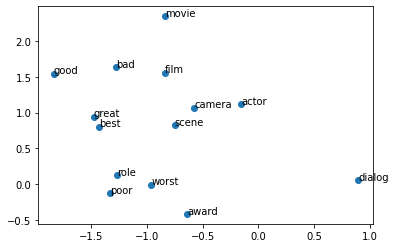

In [283]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(GloveEmbeddings)

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie', 'award']
ind_words = [vocab_5k[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

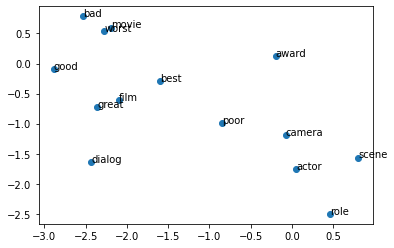

In [284]:
pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(W2VEmbeddings)

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie', 'award']
ind_words = [vocab_5k[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

**Results of projections**: We may observe that the words related to one another or belonging to the same category/field are trying to group together. For example, in the case of Word2Vec embeddings, the words *camera, actor, scene* are close to each other. For Glove embeddings, we can see a similar scenario, for example, the words *great* and *best* are closely similar.

### Application to sentiment analysis

We will now use these representations for sentiment analysis. 
The basic model, as before, will be constructed in two steps:
- A function to obtain vector representations of criticism, from text, vocabulary, and vector representations of words. Such a function (to be completed below) will associate to each word of a review its embeddings, and create the representation for the whole sentence by summing these embeddings.
- A classifier will take these representations as input and make a prediction. To achieve this, we can first use logistic regression ```LogisticRegression``` from ```scikit-learn```  

In [285]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.sum):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    #
    # To complete
    #   
    representations = np.zeros([len(texts), embeddings.shape[1]])
    for i in range(representations.shape[0]):
        words = texts[i].split()
        for word in words:
            if word not in vocabulary:
                word = 'UNK'
            representations[i] = np_func([representations[i], embeddings[vocabulary[word]]], axis=0)
        
    return representations

In [286]:
train_rep = sentence_representations(train_texts_splt, vocab_5k, GloveEmbeddings)
val_rep = sentence_representations(val_texts, vocab_5k, GloveEmbeddings)

In [287]:
from sklearn.linear_model import LogisticRegression

In [288]:
# Fit the classifier on the transformed training data and test it on the transformed validation data
clf = LogisticRegression().fit(train_rep, train_labels_splt)
print(clf.predict(val_rep))
print('Score:', clf.score(val_rep, val_labels))

[0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0
 1 1 1 1 0 0 1 1 0 1 1 1 1]
Score: 0.76


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


You can know compare the various sets of embeddings, and answer the following question:
- Why could we expect that the results obtained with embeddings pre-trained with Glove are better than others ? Is that verified ? And what changes if we remove the constraint of having the same 5000 words vocabulary as the other methods ? 

**Answer**: We may expect that the results obtained with Glove embeddings would be better since they are pre-trained, hence having some prior knowledge about the representation. While using the vocabulary of size 5k, it showed the score of 0.76, which is slightly better than the base pipeline (0.74). So the claim is verified. However, after removing the constraint of 5000 words and taking the whole vocabulary, it gave performance similar to base pipeline, i.e. 0.74. <br>
In conclusion, it happened so that for this specific case of splitting for train and validation data, there was no improvement with Glove when we used the whole vocabulary. Besides, a high value of k=100 has also an impact on this.

## Fine-tuning of a Bert model

Following the idea of the previous lab, fine-tune the lightest Bert model available on IMDB data and compare with the results you obtained just above.

In [289]:
!pip install transformers
!pip install fasttext
import transformers

In [290]:
# For downloading files directly from a Google Drive
import gdown

import numpy as np
import fasttext
import torch
from transformers import DistilBertTokenizerFast, DistilBertModel, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

import pandas as pd
import altair as alt

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [291]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accef

In [292]:
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.12.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

In [293]:
imdb_inputs = tokenizer([ex for ex in train_texts_splt],
                         truncation=True,
                         padding='max_length', 
                         return_tensors="pt")
imdb_test_inputs = tokenizer([ex for ex in val_texts],
                              truncation=True,
                              padding='max_length', 
                              return_tensors="pt")

In [294]:
class FineTuningDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [295]:
imdb_dataset = FineTuningDataset(imdb_inputs, train_labels_splt)
imdb_test_dataset = FineTuningDataset(imdb_test_inputs, val_labels)

In [296]:
imdb_model_ft = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels= max(train_labels_splt) + 1)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.12.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

In [297]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [298]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

using `logging_steps` to initialize `eval_steps` to 100
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [299]:
imdb_trainer = Trainer(
    model=imdb_model_ft,                      
    args=training_args,                  
    train_dataset=imdb_dataset,         
    eval_dataset=imdb_test_dataset,           
    compute_metrics=compute_metrics       
)

In [300]:
imdb_trainer.train()

***** Running training *****
  Num examples = 200
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 39
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=39, training_loss=0.6800793867844802, metrics={'train_runtime': 1666.9842, 'train_samples_per_second': 0.36, 'train_steps_per_second': 0.023, 'total_flos': 79480439193600.0, 'train_loss': 0.6800793867844802, 'epoch': 3.0})

In [302]:
imdb_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 50
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


{'epoch': 3.0,
 'eval_accuracy': 0.82,
 'eval_loss': 0.6143593788146973,
 'eval_runtime': 43.9893,
 'eval_samples_per_second': 1.137,
 'eval_steps_per_second': 0.068}

**Comparison of BERT model with others**: The BERT model seems to perform better, and in general, the best one among all examined models. It reached an accuracy of *0.82* with 3 epochs which is quite impressive.